<a href="https://colab.research.google.com/github/GabriellJacinto/Electrical-Behaviour-Prediction/blob/main/CMOS/NAND2/Models/simu_1/NAND2_Advanced_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Anteriormente treinamos quatro algoritmos para três variáveis alvo diferentes. Tivemos bons resultados para alguns, piores para outros, mas no geral conseguimos averiguar que Machine Learning pode servir para prever resultados de simulações elétricas. Dessa vez queremos treinar algoritmos mais avançados que nos retornem multi outputs, com uma variação maior de valores nas variáveis explicativas. Os valores a serem permutados nos dados da simulação Monte Carlo (spectre) de um circuito inversor serão:
* NFET Phig*
* PFET Phig*
* Temperature (-25, 25, 0, 50, 75, 100°C)
* Voltage (0.6, 0.7, 0.8, 0.9V)
* Capacitance (1f, 4f, 8f, 16f)
* Fins (1, 2, 3, 4, 5)
* Hfin (3.2e-8)
* Length (2.1e-8)

Os nossos algoritmos precisam prever em um output (preferencialmente) as variáveis de energia, atraso de subida e atraso de descida (```iint```, ```tplh``` e ```tphl```respectivamente). **Não irei trabalhar com regressores lineares dessa vez**. Alguns algoritmos que tenho em mente:
   

- [ ] Uma ou duas arquiteturas de Rede Neural
- [ ] SVR com um kernel polinomial ou similar
- [ ] RandomForest
- [ ] MultiOutputEstimator para os últimos dois



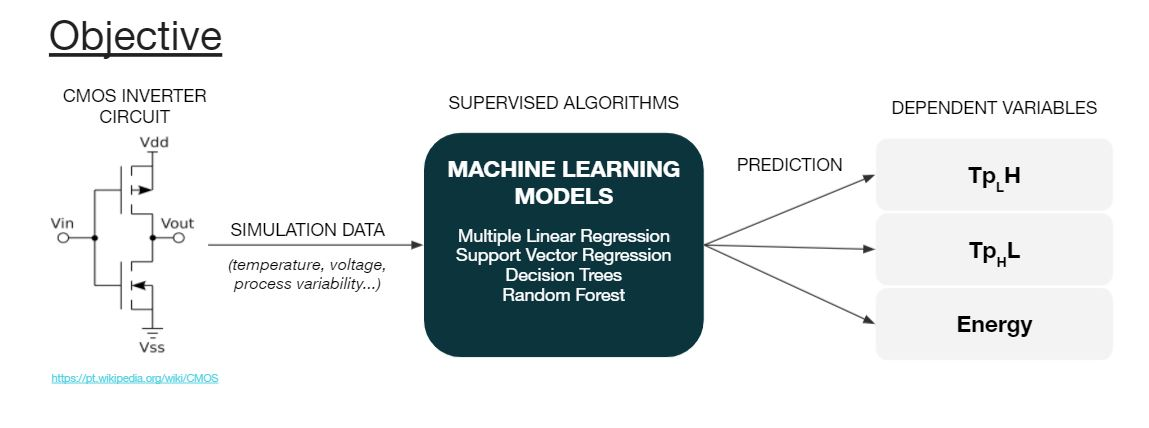

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [5]:
!pwd

/home/orion23/Desktop/Electrical-Behaviour-Prediction/FINFET/7nm/NOT/Models/sim1


In [7]:
path = "../../Data/sim1/simResults_NOTfet"
os.chdir(path)
print("Current path:", os.getcwd())
print("Files:")
for file in os.listdir():
  print(" ", file)

Current path: /home/orion23/Desktop/Electrical-Behaviour-Prediction/FINFET/7nm/NOT/Data/sim1/simResults_NOTfet
Files:
  all_results_inverter.csv
  completed.csv
  log.txt
  parameters.json
  cases.csv


# Ajustando o .csv

In [75]:
data = pd.read_csv('all_results_inverter.csv', index_col=0)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48480 entries, 0 to 48479
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1                     48000 non-null  float64
 1   2                     48000 non-null  float64
 2   LoadCap               48000 non-null  object 
 3   vdd                   48000 non-null  float64
 4   number_fin            48000 non-null  float64
 5   index                 48480 non-null  int64  
 6   temp                  48480 non-null  int64  
 7   montecarlo_iteration  48480 non-null  int64  
 8   tphl                  48480 non-null  float64
 9   tplh                  48480 non-null  float64
 10  total_power           48480 non-null  float64
 11  iint                  48480 non-null  float64
 12  temper                48480 non-null  int64  
 13  alter#                48480 non-null  int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 5.5+ MB


In [77]:
#data = data.apply(pd.to_numeric, errors='coerce')
data.isna().sum()

1                       480
2                       480
LoadCap                 480
vdd                     480
number_fin              480
index                     0
temp                      0
montecarlo_iteration      0
tphl                      0
tplh                      0
total_power               0
iint                      0
temper                    0
alter#                    0
dtype: int64

In [78]:
data = data.dropna()
data.isna().sum()

1                       0
2                       0
LoadCap                 0
vdd                     0
number_fin              0
index                   0
temp                    0
montecarlo_iteration    0
tphl                    0
tplh                    0
total_power             0
iint                    0
temper                  0
alter#                  0
dtype: int64

In [79]:
data = data.rename(columns={'1': 'nfetPhig', 
                            '2': 'pfetPhig', 
                            'alter#': 'alter', 
                            'vdd': 'voltage', 
                            'LoadCap': 'capacitance',
                            'temp': 'temperature',
                            'number_fin': 'finsNumber',
                            'montecarlo_iteration': 'monteCarloIteration',
                            'total_power': 'totalPower',
                            'iint': 'energy',
                            'tphl': 'tphL',
                            'tplh': 'tplH'
                            })

data = data.drop("temper", axis=1)
data = data.drop("alter", axis=1)
data = data.drop("index", axis=1)

data["finLength"] = 2.1e-8
data["finHeight"] = 3.2e-8

In [80]:
data["capacitance"] = data["capacitance"].map(lambda x: (float(x[:-1]))*10**(-15))

In [81]:
data.capacitance.unique()

array([1.0e-15, 4.0e-15, 8.0e-15, 1.6e-14])

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 0 to 48473
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nfetPhig             48000 non-null  float64
 1   pfetPhig             48000 non-null  float64
 2   capacitance          48000 non-null  float64
 3   voltage              48000 non-null  float64
 4   finsNumber           48000 non-null  float64
 5   temperature          48000 non-null  int64  
 6   monteCarloIteration  48000 non-null  int64  
 7   tphL                 48000 non-null  float64
 8   tplH                 48000 non-null  float64
 9   totalPower           48000 non-null  float64
 10  energy               48000 non-null  float64
 11  finLength            48000 non-null  float64
 12  finHeight            48000 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 5.1 MB


In [83]:
data.to_csv('treated_data_inverter.csv') 
#""""!cp treated_data.csv "/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data" #copiar para o drive!"""

# Limpando e Explorando os Dados

In [84]:
data = pd.read_csv("treated_data_inverter.csv", index_col=0)
data.head()

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,monteCarloIteration,tphL,tplH,totalPower,energy,finLength,finHeight
0,4.370067,4.852864,1.000000e-15,0.6,1.0,-25,0,1.234720e-11,1.879330e-11,-9.512740e-09,-6.341830e-16,2.100000e-08,3.200000e-08
1,4.370806,4.873612,1.000000e-15,0.6,1.0,-25,1,1.230100e-11,1.582600e-11,-9.601460e-09,-6.400970e-16,2.100000e-08,3.200000e-08
2,4.333499,4.850897,1.000000e-15,0.6,1.0,-25,2,1.232850e-11,1.470250e-11,-9.648810e-09,-6.432540e-16,2.100000e-08,3.200000e-08
3,4.407237,4.856645,1.000000e-15,0.6,1.0,-25,3,1.128970e-11,1.594150e-11,-9.603980e-09,-6.402650e-16,2.100000e-08,3.200000e-08
4,4.387795,4.770993,1.000000e-15,0.6,1.0,-25,4,1.353270e-11,1.560170e-11,-9.595290e-09,-6.396860e-16,2.100000e-08,3.200000e-08


In [87]:
inp_var = ["capacitance", "voltage", "finHeight", "finLength", "temperature", "finsNumber"]
unique = {}
for col in inp_var:
  unique[col] = list(np.sort(data[col].unique()))
tmp = data[inp_var]
# Verifica quantas vezes o mesmo caso é repetido
n_repetitions = tmp.shape[0]
for i in range(1, tmp.shape[0]):
  if (not tmp.iloc[0].equals(tmp.iloc[i])):
    n_repetitions = i
    break

n_cases = tmp.shape[0]//n_repetitions
idx = []
idx.append(np.vstack([np.arange(n_cases)]*n_repetitions).T.reshape(-1))
idx.append(np.concatenate([np.arange(n_repetitions)]*n_cases))
data.index = pd.MultiIndex.from_tuples(list(zip(*idx)), names=["case", "idx"])
data

ValueError: Length mismatch: Expected axis has 48000 elements, new values have 47975 elements

In [ ]:
from scipy.stats import zscore
out_var = ["tphL", "tplH", "energy", "totalPower"]
filtered_list = []
for case in data.index.unique(level="case"):
    tmp = data.loc[slice(case, case), :]
    not_outlier = (np.abs(zscore(tmp[out_var])) < 3).all(axis=1)
    filtered_list.append(tmp[not_outlier])
filtered = pd.concat(filtered_list)
filtered

In [110]:
#df = filtered.copy()
df = data.copy()
df

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,monteCarloIteration,tphL,tplH,totalPower,energy,finLength,finHeight
0,4.370067,4.852864,1.000000e-15,0.6,1.0,-25,0,1.234720e-11,1.879330e-11,-9.512740e-09,-6.341830e-16,2.100000e-08,3.200000e-08
1,4.370806,4.873612,1.000000e-15,0.6,1.0,-25,1,1.230100e-11,1.582600e-11,-9.601460e-09,-6.400970e-16,2.100000e-08,3.200000e-08
2,4.333499,4.850897,1.000000e-15,0.6,1.0,-25,2,1.232850e-11,1.470250e-11,-9.648810e-09,-6.432540e-16,2.100000e-08,3.200000e-08
3,4.407237,4.856645,1.000000e-15,0.6,1.0,-25,3,1.128970e-11,1.594150e-11,-9.603980e-09,-6.402650e-16,2.100000e-08,3.200000e-08
4,4.387795,4.770993,1.000000e-15,0.6,1.0,-25,4,1.353270e-11,1.560170e-11,-9.595290e-09,-6.396860e-16,2.100000e-08,3.200000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48469,4.336670,4.776053,1.600000e-14,0.9,5.0,100,90,3.958400e-11,3.791880e-11,-5.024640e-07,-2.233170e-14,2.100000e-08,3.200000e-08
48470,4.379719,4.855940,1.600000e-14,0.9,5.0,100,91,4.707970e-11,3.427140e-11,-1.183370e-06,-5.259410e-14,2.100000e-08,3.200000e-08
48471,4.435190,4.791605,1.600000e-14,0.9,5.0,100,92,3.553080e-11,3.731970e-11,-5.697050e-07,-2.532020e-14,2.100000e-08,3.200000e-08
48472,4.323838,4.781360,1.600000e-14,0.9,5.0,100,93,4.335980e-11,3.216300e-11,-2.302380e-06,-1.023280e-13,2.100000e-08,3.200000e-08


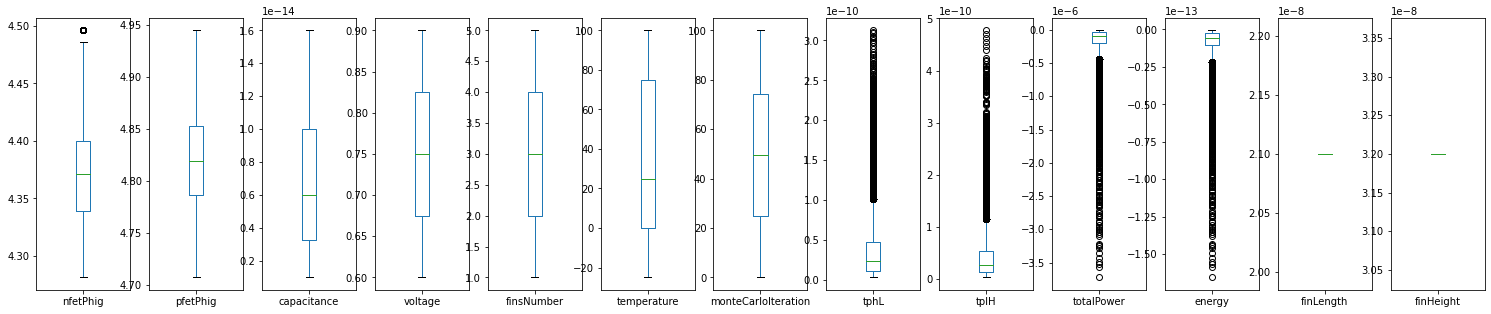

<Figure size 432x288 with 0 Axes>

In [86]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
_ = plt.figure()
plt.show()

Hmm, ```tphl```, ```tplh```, ```iint```, ```width_nmos``` e ```length``` estão com uma distribuição bizarra. Muitos ouliers para os três primeiros. Agora para os dois últimos não entendo, eu que criei essas colunas... Vamos ver as quantidades então 

In [ ]:
df.describe()

,nmos:@:var:@:IGNC,pmos:@:varp:@:IGNC,load,Vin,pmosW,nmosW,tplha,tphla,tplhb,tphlb,iint,temper,nmosL,pmosL
count,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06
mean,-6.150582e-03,3.397423e-02,7.244111e-15,7.501625e-01,1.400069e-07,2.433529e-07,2.622477e-10,9.085608e-11,2.763596e-10,9.262183e-11,-1.289349e-14,3.753401e+01,3.599818e-08,3.599818e-08
std,9.442599e-01,9.695977e-01,5.629865e-15,1.117503e-01,5.716561e-08,1.181435e-07,3.726377e-10,1.380910e-10,3.836379e-10,1.382947e-10,8.896139e-15,4.270471e+01,4.000000e-09,4.000000e-09
min,-3.418700e+00,-3.526500e+00,1.000000e-15,6.000000e-01,7.000000e-08,7.000000e-08,5.723474e-12,2.827306e-12,6.222745e-12,3.608238e-12,-4.433770e-14,-2.500000e+01,3.200000e-08,3.200000e-08
25%,-6.709000e-01,-6.142000e-01,1.000000e-15,7.000000e-01,7.000000e-08,1.400000e-07,5.928093e-11,2.067752e-11,6.719371e-11,2.213735e-11,-1.981028e-14,0.000000e+00,3.200000e-08,3.200000e-08
50%,-4.356000e-02,9.554000e-02,4.000000e-15,8.000000e-01,1.400000e-07,2.800000e-07,1.368588e-10,4.633930e-11,1.481153e-10,4.795036e-11,-1.066714e-14,5.000000e+01,3.200000e-08,3.200000e-08
75%,6.466000e-01,6.798000e-01,8.000000e-15,9.000000e-01,2.100000e-07,3.400000e-07,3.068778e-10,1.027366e-10,3.236275e-10,1.048101e-10,-5.797403e-15,7.500000e+01,4.000000e-08,4.000000e-08
max,2.877400e+00,3.271700e+00,1.600000e-14,9.000000e-01,2.100000e-07,4.200000e-07,4.846905e-09,2.514691e-09,5.071540e-09,2.539054e-09,-1.547892e-15,1.000000e+02,4.000000e-08,4.000000e-08


In [ ]:
df['width_nmos'].value_counts()

KeyError: ignored

In [ ]:
df['width_pmos'].value_counts()

3.400000e-07    144000
1.400000e-07     96000
2.100000e-07     96000
4.200000e-07     96000
2.800000e-07     96000
7.000000e-08     48000
Name: width_pmos, dtype: int64

In [ ]:
df['temper'].value_counts()

 100.0    96000
-25.0     96000
 75.0     96000
 50.0     96000
 25.0     96000
 0.0      96000
Name: temper, dtype: int64

Ah sim, faz sentido, não variamos tanto esses quanto o ```width_nmos```, então eles tem que ficar naquela faixa mesmo. Agora os atrasos e a energia possuem muito outliers. Vou começar a remover pelos atrasos, ele está mais fácil de discernir do que a energia, depois cuido dessa.

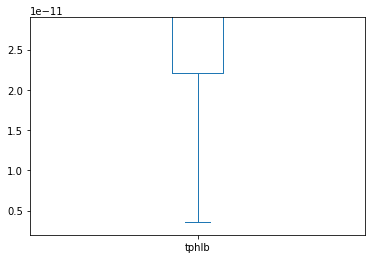

In [ ]:
df['tphlb'].plot(kind='box')
plt.ylim(2e-12, 2.9e-11)
plt.show()

In [ ]:
df = df[(2e-12<=df.tphl)&(df.tphl<=2.9e-11)] #filtrando para deixar no intervalo acima

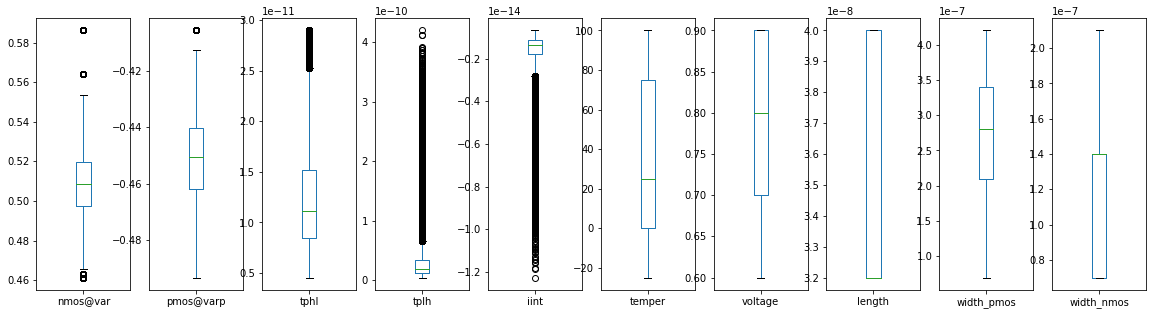

<Figure size 432x288 with 0 Axes>

In [ ]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

O ```tphl``` parece ter funcionado, mas ainda estamos com bastante outliers no ```tplh``` e por mais que o ```iint``` tenha reduzido aparentemente, ainda precisa de ajuste. Vamos mexer no ```tplh```

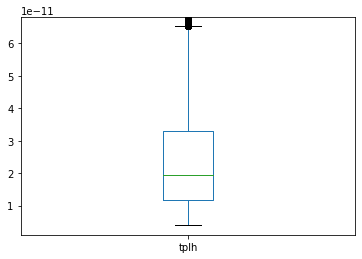

In [ ]:
df['tplh'].plot(kind='box')
plt.ylim(1e-12, 6.8e-11)
plt.show()

In [ ]:
df = df[(1e-12<=df.tplh)&(df.tplh<=6.8e-11)]

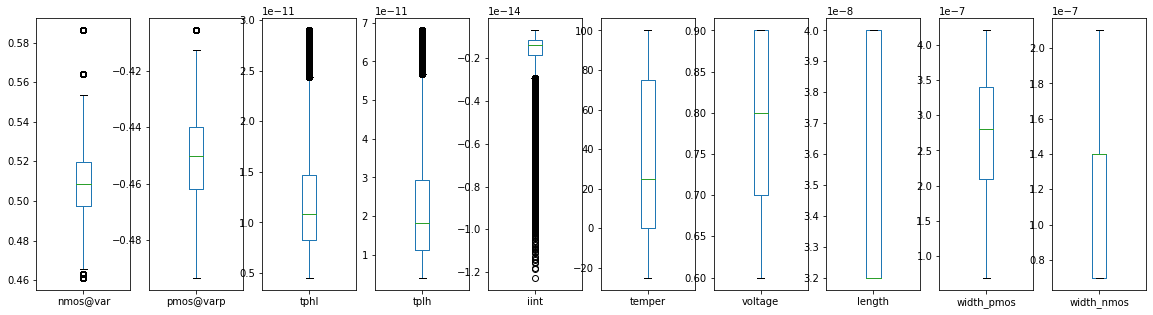

<Figure size 432x288 with 0 Axes>

In [ ]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

Melhorou bastante, mas o ```iint``` possui muito outliers ainda. Aparentemente o ```length_n&p = 20e-9```  é que estava gerando esses valores extremos...

(-3e-15, -3e-16)


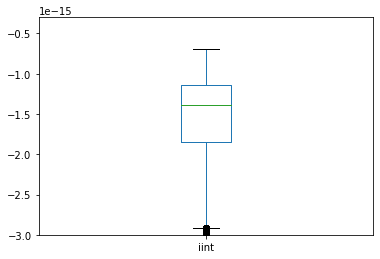

In [ ]:
df.iint.plot(kind='box')
print(plt.ylim(-3e-15,-3e-16))
plt.show()

In [ ]:
df = df[(-3e-15<=df.iint)]

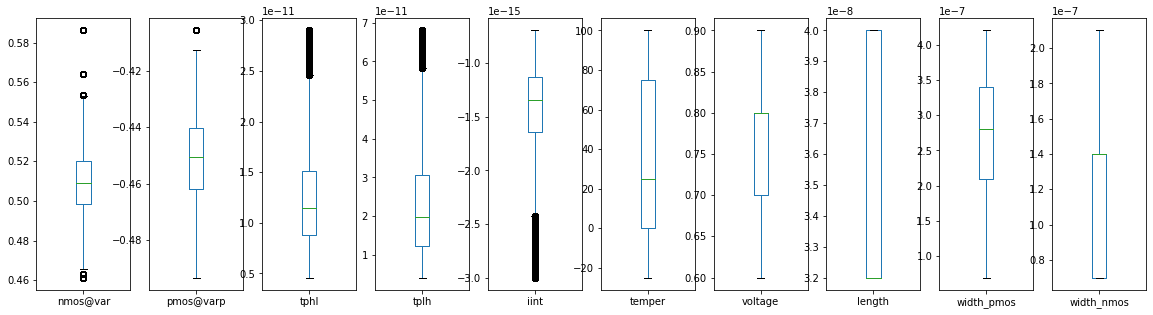

<Figure size 432x288 with 0 Axes>

In [ ]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

Bem melhor sinceramente. Vamos ver o quanto nos sobrou das 576.000 observações

In [ ]:
df.describe()
print(576000-459842, (116158/576000)*100)

116158 20.166319444444444


116.158 outliers! Representa 20% dos dados. Vamos checar a porcentagem de perda para cada valor das variáveis explicativas

In [ ]:
((data['width_nmos'].value_counts() - df['width_nmos'].value_counts())/data['width_nmos'].value_counts().sum())*100

NameError: ignored

In [ ]:
((data['width_pmos'].value_counts() - df['width_pmos'].value_counts())/data['width_pmos'].value_counts().sum())*100

7.000000e-08    2.948437
1.400000e-07    5.067882
2.100000e-07    2.264931
2.800000e-07    2.419792
3.400000e-07    4.220313
4.200000e-07    3.244965
Name: width_pmos, dtype: float64

In [ ]:
((data['length'].value_counts() - df['length'].value_counts())/data['length'].value_counts().sum())*100

3.200000e-08     8.614931
4.000000e-08    11.551389
Name: length, dtype: float64

In [ ]:
((data['temper'].value_counts() - df['temper'].value_counts())/data['temper'].value_counts().sum())*100

-25.0     0.541667
 0.0      1.042882
 25.0     2.091667
 50.0     3.804340
 75.0     5.625868
 100.0    7.059896
Name: temper, dtype: float64

Precisamos colocar os valores em uma escala maior para que os algoritmos possam aprender melhor, logo vou dividi-los pelo valor máximo de cada

In [ ]:
df.describe()

,nmos:@:var:@:IGNC,pmos:@:varp:@:IGNC,load,Vin,pmosW,nmosW,tplha,tphla,tplhb,tphlb,iint,temper,nmosL,pmosL
count,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06,3.371061e+06
mean,-6.150582e-03,3.397423e-02,7.244111e-15,7.501625e-01,1.400069e-07,2.433529e-07,2.622477e-10,9.085608e-11,2.763596e-10,9.262183e-11,-1.289349e-14,3.753401e+01,3.599818e-08,3.599818e-08
std,9.442599e-01,9.695977e-01,5.629865e-15,1.117503e-01,5.716561e-08,1.181435e-07,3.726377e-10,1.380910e-10,3.836379e-10,1.382947e-10,8.896139e-15,4.270471e+01,4.000000e-09,4.000000e-09
min,-3.418700e+00,-3.526500e+00,1.000000e-15,6.000000e-01,7.000000e-08,7.000000e-08,5.723474e-12,2.827306e-12,6.222745e-12,3.608238e-12,-4.433770e-14,-2.500000e+01,3.200000e-08,3.200000e-08
25%,-6.709000e-01,-6.142000e-01,1.000000e-15,7.000000e-01,7.000000e-08,1.400000e-07,5.928093e-11,2.067752e-11,6.719371e-11,2.213735e-11,-1.981028e-14,0.000000e+00,3.200000e-08,3.200000e-08
50%,-4.356000e-02,9.554000e-02,4.000000e-15,8.000000e-01,1.400000e-07,2.800000e-07,1.368588e-10,4.633930e-11,1.481153e-10,4.795036e-11,-1.066714e-14,5.000000e+01,3.200000e-08,3.200000e-08
75%,6.466000e-01,6.798000e-01,8.000000e-15,9.000000e-01,2.100000e-07,3.400000e-07,3.068778e-10,1.027366e-10,3.236275e-10,1.048101e-10,-5.797403e-15,7.500000e+01,4.000000e-08,4.000000e-08
max,2.877400e+00,3.271700e+00,1.600000e-14,9.000000e-01,2.100000e-07,4.200000e-07,4.846905e-09,2.514691e-09,5.071540e-09,2.539054e-09,-1.547892e-15,1.000000e+02,4.000000e-08,4.000000e-08


## Alterando a escala

### Escalando pelo MinMaxScaler

In [111]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_scaled[["energy", "tphL", "tplH"]])

MinMaxScaler()

In [112]:
print(minMaxScaler.data_max_)
print(minMaxScaler.data_min_)

[-5.80399e-16  3.12585e-10  4.77152e-10]
[-1.65513e-13  3.25429e-12  3.22053e-12]


In [113]:
df_scaled[["energy", "tphL", "tplH"]] = minMaxScaler.transform(df_scaled[["energy", "tphL", "tplH"]])

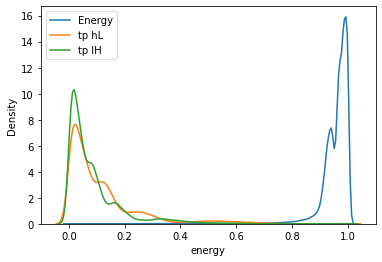

In [114]:
sns.kdeplot(df_scaled.energy, label = 'Energy')
sns.kdeplot(df_scaled.tphL, label = 'tp hL')
sns.kdeplot(df_scaled.tplH, label = 'tp lH')
plt.legend()
plt.show()

Muito melhor, agora todos estão na mesma escala. Ainda assim, quero testar uma outra estratégia, a qual consiste em apenas remover a maginitude dos valores para eles ficarem menos próximos de zero. Até porque o detalhe em fazer essa técnica de cima é que estou escalando os valores antes de fazer o training dataset, o que não é uma prática comum e estou fazendo apenas para os target values

## Correlações

### Visualizações (demoram muito para rodar! >1h Cuidado)

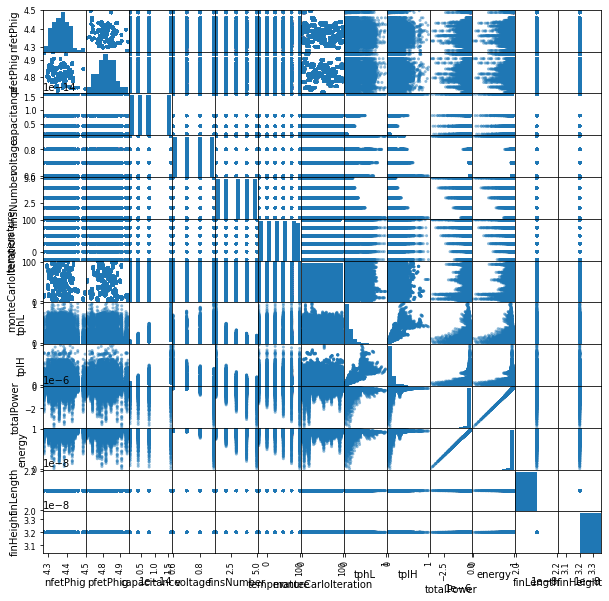

<Figure size 432x288 with 0 Axes>

In [117]:
pd.plotting.scatter_matrix(df_scaled, figsize=(10,10))
plt.figure()
plt.show()

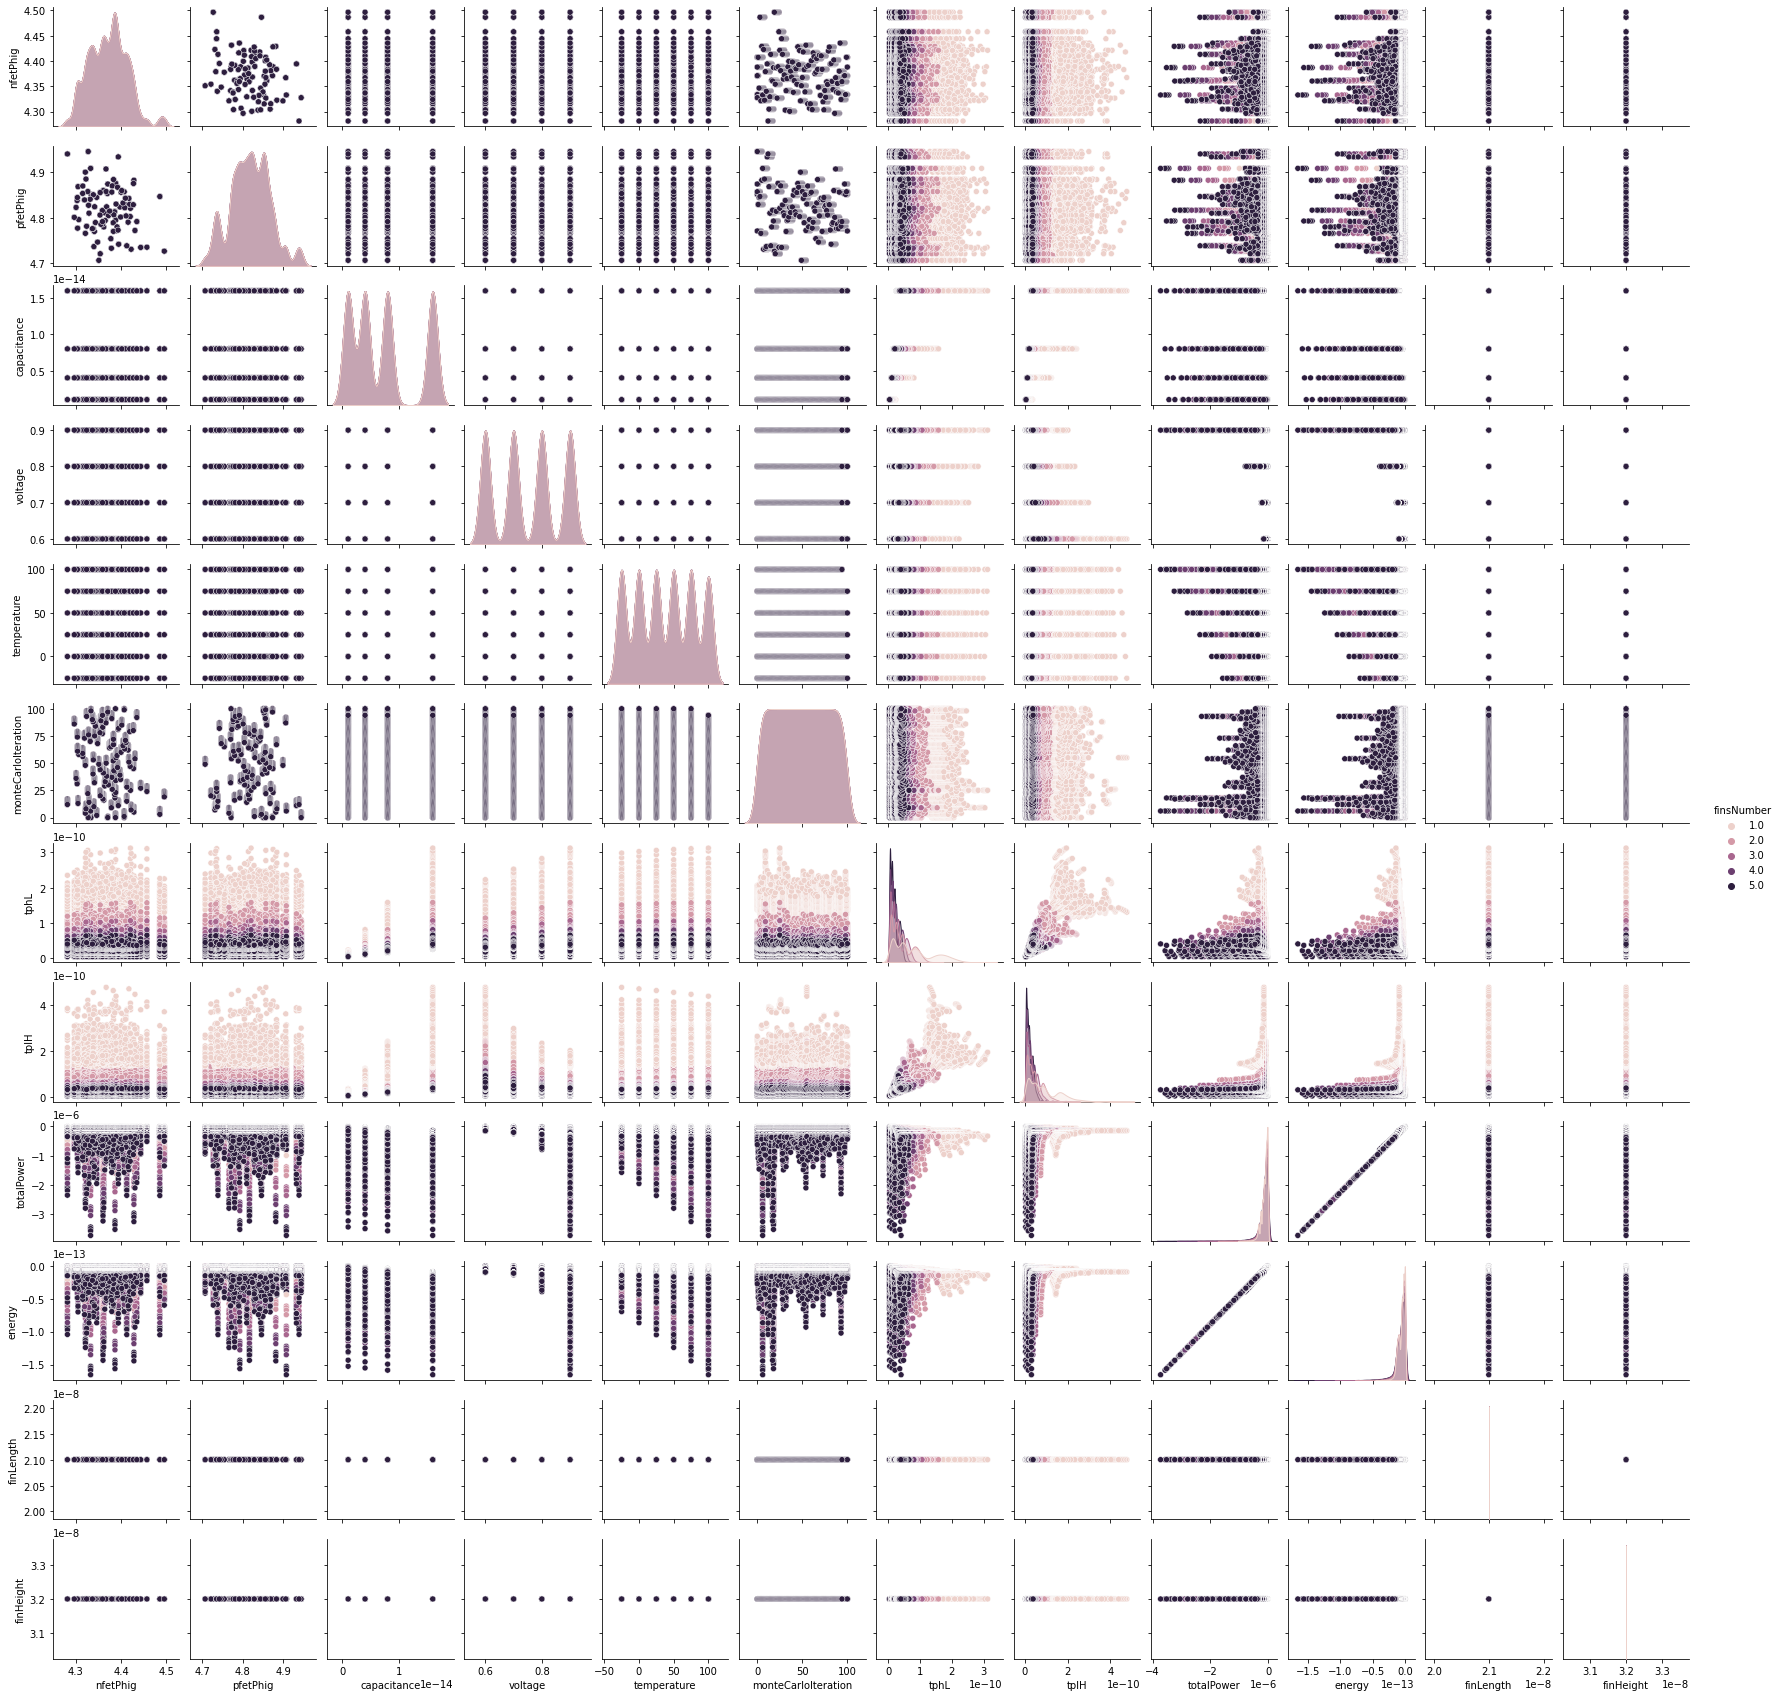

In [119]:
_ = sns.pairplot(df, hue="finsNumber", height=2, diag_kind="kde")
plt.show()

In [ ]:
_ = sns.pairplot(df, hue="temperature", height=2, diag_kind="kde")
plt.show()

### Pearson

In [122]:
temp_data = df_scaled.copy()

#temp_data = temp_data.drop(columns=['energy', 'tphL','tplH'])

In [123]:
temp_data

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,monteCarloIteration,tphL,tplH,totalPower,energy,finLength,finHeight
0,4.370067,4.852864,1.000000e-15,0.6,1.0,-25,0,0.029395,0.032859,-9.512740e-09,0.999674,2.100000e-08,3.200000e-08
1,4.370806,4.873612,1.000000e-15,0.6,1.0,-25,1,0.029246,0.026598,-9.601460e-09,0.999638,2.100000e-08,3.200000e-08
2,4.333499,4.850897,1.000000e-15,0.6,1.0,-25,2,0.029335,0.024227,-9.648810e-09,0.999619,2.100000e-08,3.200000e-08
3,4.407237,4.856645,1.000000e-15,0.6,1.0,-25,3,0.025977,0.026841,-9.603980e-09,0.999637,2.100000e-08,3.200000e-08
4,4.387795,4.770993,1.000000e-15,0.6,1.0,-25,4,0.033228,0.026124,-9.595290e-09,0.999641,2.100000e-08,3.200000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48469,4.336670,4.776053,1.600000e-14,0.9,5.0,100,90,0.117446,0.073214,-5.024640e-07,0.868120,2.100000e-08,3.200000e-08
48470,4.379719,4.855940,1.600000e-14,0.9,5.0,100,91,0.141678,0.065518,-1.183370e-06,0.684637,2.100000e-08,3.200000e-08
48471,4.435190,4.791605,1.600000e-14,0.9,5.0,100,92,0.104343,0.071950,-5.697050e-07,0.850001,2.100000e-08,3.200000e-08
48472,4.323838,4.781360,1.600000e-14,0.9,5.0,100,93,0.129653,0.061069,-2.302380e-06,0.383096,2.100000e-08,3.200000e-08


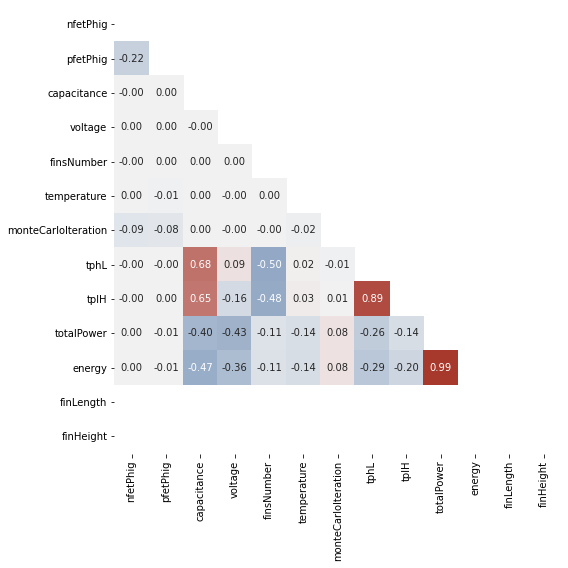

In [124]:
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(temp_data.corr(), dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(temp_data.corr(), mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig('pearson.pdf') 
plt.show()

### Kendall

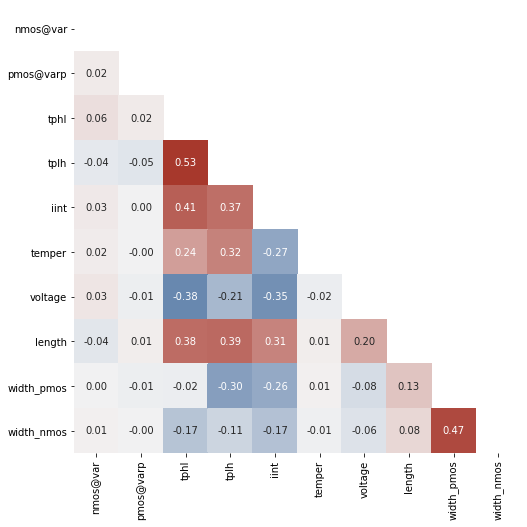

In [ ]:
kendall = df.corr(method='kendall')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(kendall, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(kendall, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.show();

### Spearman

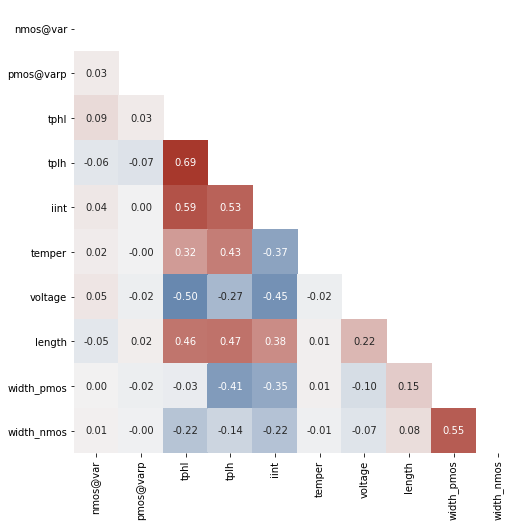

In [ ]:
spearman = df.corr(method='spearman')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(spearman, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(spearman, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.show();

# Metrics

In [120]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(_error(actual[seasonality:], _naive_forecasting(actual, seasonality)))
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(np.sum(np.square(_error(actual, predicted) - __mae))/(len(actual) - 1))


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(np.sum(np.square(_percentage_error(actual, predicted) - __mape))/(len(actual) - 1))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual))))


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(np.sum(np.square(actual - predicted)) / np.sum(np.square(actual - np.mean(actual))))


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


METRICS = {
    'mse': mse,
    'rmse': rmse,
    'nrmse': nrmse,
    'me': me,
    'mae': mae,
    'mad': mad,
    'gmae': gmae,
    'mdae': mdae,
    'mpe': mpe,
    'mape': mape,
    'mdape': mdape,
    'smape': smape,
    'smdape': smdape,
    'maape': maape,
    'mase': mase,
    'std_ae': std_ae,
    'std_ape': std_ape,
    'rmspe': rmspe,
    'rmdspe': rmdspe,
    'rmsse': rmsse,
    'inrse': inrse,
    'rrse': rrse,
    'mre': mre,
    'rae': rae,
    'mrae': mrae,
    'mdrae': mdrae,
    'gmrae': gmrae,
    'mbrae': mbrae,
    'umbrae': umbrae,
    'mda': mda,
}


def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('mae', 'mse', 'smape', 'umbrae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [ ]:
from sklearn.preprocessing import Normalizer
def mape_normalized(actual, pred, plus_one = False):
  norm_actual = Normalizer().fit_transform(actual.reshape(-1, 1))
  norm_pred = Normalizer().fit_transform(pred.reshape(-1, 1))
  if plus_one:
    norm_actual = norm_actual + 1
    norm_pred = norm_pred + 1
  return mape(norm_actual, norm_pred)

# Train, Validation, Test Sets

Apenas testando para o Atraso de Descida

In [128]:
X = df_scaled.drop(columns=['tphL', 'tplH', 'energy', 'totalPower','monteCarloIteration'])
y = df_scaled[['tphL', 'tplH', 'energy']]

print(X.shape)
print(y.shape)

(48000, 8)
(48000, 3)


In [129]:
X.describe()

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,finLength,finHeight
count,48000.000000,48000.000000,4.800000e+04,48000.000000,48000.000000,48000.000000,4.800000e+04,4.800000e+04
mean,4.371422,4.817980,7.250000e-15,0.750000,3.000000,36.875000,2.100000e-08,3.200000e-08
std,0.041990,0.049145,5.629224e-15,0.111805,1.414228,42.446793,9.926271e-24,6.617514e-24
min,4.281295,4.706879,1.000000e-15,0.600000,1.000000,-25.000000,2.100000e-08,3.200000e-08
25%,4.338745,4.785972,3.250000e-15,0.675000,2.000000,0.000000,2.100000e-08,3.200000e-08
50%,4.371549,4.818547,6.000000e-15,0.750000,3.000000,25.000000,2.100000e-08,3.200000e-08
75%,4.399487,4.852915,1.000000e-14,0.825000,4.000000,75.000000,2.100000e-08,3.200000e-08
max,4.496100,4.944579,1.600000e-14,0.900000,5.000000,100.000000,2.100000e-08,3.200000e-08


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 23

Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=seed, test_size=0.25)

# grellert esse é o mais recomendado
scaler = StandardScaler().fit(Xtr)
Xtr_sc = scaler.transform(Xtr)
Xte_sc = scaler.transform(Xte)

X_train, X_val, y_train, y_val = train_test_split(Xtr_sc, ytr, random_state=seed, test_size=0.33)

print("Test set X", Xte.shape)
print("Test set y", yte.shape)
print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (12000, 8)
Test set y (12000, 3)
Train set X (24120, 8)
Train set y (24120, 3)
Validation set X (11880, 8)
Validation set y (11880, 3)


In [131]:
y_train.describe()

,tphL,tplH,energy
count,24120.000000,24120.000000,24120.000000
mean,0.113698,0.085658,0.957644
std,0.131436,0.101312,0.055019
min,0.000000,0.000000,0.042060
25%,0.028149,0.020549,0.940854
50%,0.067851,0.050766,0.969305
75%,0.144434,0.107978,0.987979
max,1.000000,1.000000,0.999681


# New Models


In [132]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## Shortlisting

In [133]:
clfs = [RandomForestRegressor(), LinearRegression(), SVR(kernel='rbf'), DecisionTreeRegressor()]

label: tphL
clf: RandomForestRegressor, mse: 0.0006254250329249197, r2: 0.9645762617946244
clf: LinearRegression, mse: 0.0050326694405820735, r2: 0.7149523038698469
clf: SVR, mse: 0.0021386615695792787, r2: 0.878867356497755
clf: DecisionTreeRegressor, mse: 0.0011061651647725809, r2: 0.9373473987352948
label: tplH
clf: RandomForestRegressor, mse: 0.0006716981042479348, r2: 0.9342915379884178
clf: LinearRegression, mse: 0.003181905109598427, r2: 0.6887320513542297
clf: SVR, mse: 0.0019311753815068997, r2: 0.811083932810074
clf: DecisionTreeRegressor, mse: 0.0011427984894323317, r2: 0.8882064268830505


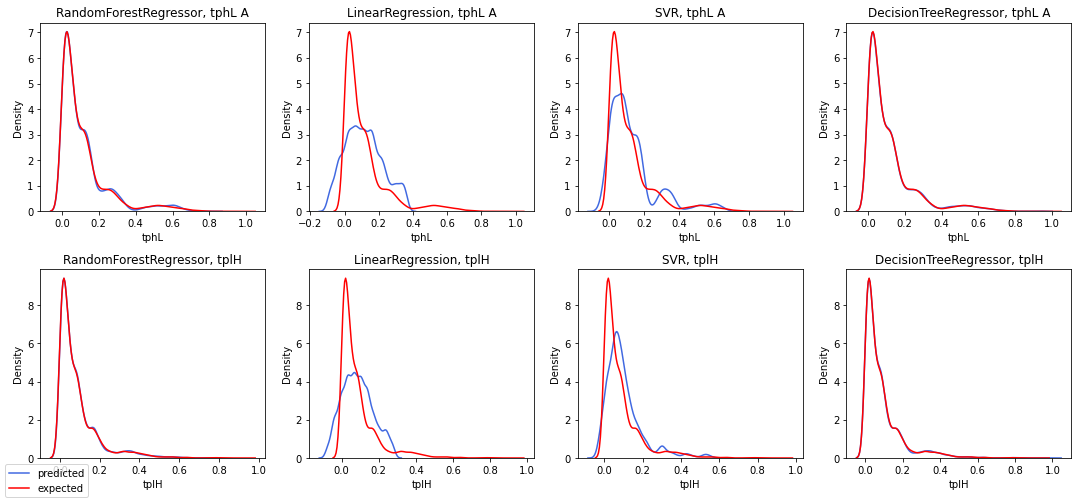

In [142]:
fig, ax = plt.subplots(2,4, figsize = (15,7))
#modelos para TPHL
print('label: tphL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphL), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphL), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0][i], color = 'red')
    ax[0][i].set_title(f'{clf.__class__.__name__}, tphL A')

#modelos para TPLH
print('label: tplH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplH), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplH), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1][i], color = 'red')
    ax[1][i].set_title(f'{clf.__class__.__name__}, tplH')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc='lower left')
plt.savefig('delays_inverter.pdf') 
plt.show()

label: tphL
clf: RandomForestRegressor, mse: 0.0006280531732356235, r2: 0.9644274053379233
clf: LinearRegression, mse: 0.0050326694405820735, r2: 0.7149523038698469
clf: SVR, mse: 0.0021386615695792787, r2: 0.878867356497755
clf: DecisionTreeRegressor, mse: 0.0011234152578737321, r2: 0.9363703627200017


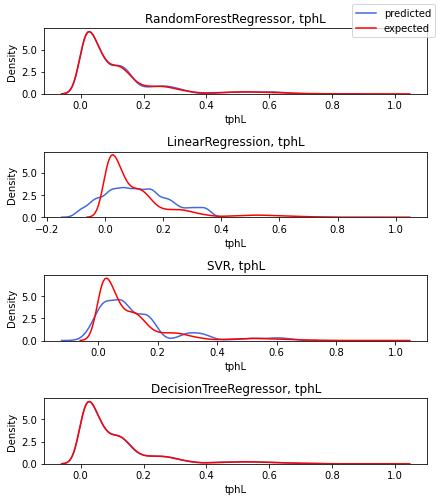

In [153]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPHL = {}

#modelos para TPHL
print('label: tphL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    pred_TPHL['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphla), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphla), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tphL')
    
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig('tphL_inverter.pdf') 
#plt.xlim([-0.05, 0.5])
plt.show()

label: tplH
clf: RandomForestRegressor, mse: 0.0006767443589120884, r2: 0.9337978911688074
clf: LinearRegression, mse: 0.003181905109598427, r2: 0.6887320513542297
clf: SVR, mse: 0.0019311753815068997, r2: 0.811083932810074
clf: DecisionTreeRegressor, mse: 0.001120682453312551, r2: 0.8903699147804155


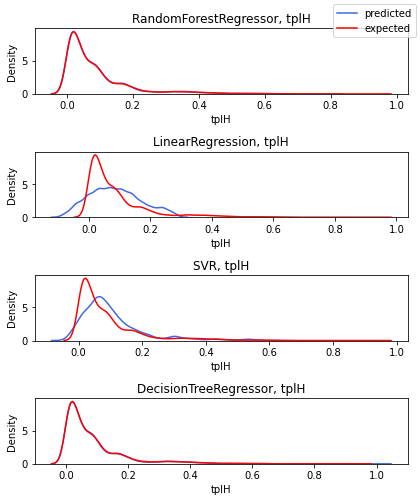

In [154]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPLH = {}
print('label: tplH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    pred_TPLH['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplH), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplH), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tplH')
    ax[i].set(xlabel='tplH')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig('tplH_inverter.pdf')
plt.show()

label: Energy
clf: RandomForestRegressor, mse: 0.0005933980435553896, r2: 0.7795486902936044
clf: LinearRegression, mse: 0.0016222088828417296, r2: 0.397338638501212
clf: SVR, mse: 0.00452593331847508, r2: -0.6814142522674362
clf: DecisionTreeRegressor, mse: 0.0010672251163244644, r2: 0.6035187894526186


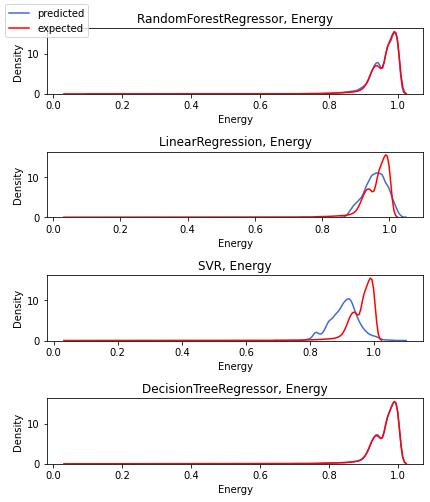

In [155]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
print('label: Energy')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.energy), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.energy), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, Energy')
    ax[i].set(xlabel='Energy')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc="upper left")
plt.savefig('energy_inverter.pdf')
plt.show()

Time to Fine-tune! Seguir com SVR (...) e o Random Forest

# Inference Time

In [151]:
import time

In [152]:
test_case = X_val[1,:]

In [157]:
#def pred_time(clfs: dict, value: np.array): -> List

##TPLH
print("\n TPLH")
for k in pred_TPLH.values():
  start_time = time.time()
  k_pred = k.predict(test_case.reshape(1, -1))
  print("{}: {:.5f} secs".format(k, time.time() - start_time))


##TPHL
print("\n TPHL")
for a in pred_TPHL.values():
  start_time = time.time()
  a_pred = a.predict(test_case.reshape(1, -1))
  print("{}: {:.5f} secs".format(a.__class__.__name__, time.time() - start_time))

##IINT
print("\n IINT")
for b in pred_IINT.values():
  start_time = time.time()
  b_pred = b.predict(test_case.reshape(1, -1))
  print("{}: {:.5f} secs".format(b.__class__.__name__, time.time() - start_time))

  
###TPHL
#print("\n TPHLA")
#for a in pred_TPHLA.values():
#  start_time = time.time()
#  a_pred = a.predict(test_case.reshape(1, -1))
#  print("{}: {:.4f} secs".format(a.__class__.__name__, time.time() - start_time))

#print("\n TPLHB")
#for k in pred_TPLHB.values():
#  start_time = time.time()
#  k_pred = k.predict(test_case.reshape(1, -1))
#  print("{}: {:.4f} secs".format(k, time.time() - start_time))


 TPLH
RandomForestRegressor(): 0.00675 secs
LinearRegression(): 0.00014 secs
SVR(): 0.00022 secs
DecisionTreeRegressor(): 0.00013 secs

 TPHL
RandomForestRegressor: 0.00569 secs
LinearRegression: 0.00010 secs
SVR: 0.00017 secs
DecisionTreeRegressor: 0.00008 secs

 IINT
RandomForestRegressor: 0.00691 secs
LinearRegression: 0.00010 secs
SVR: 0.00017 secs
DecisionTreeRegressor: 0.00008 secs


## Fine-tuning

### Random Forest

In [158]:
params = {'n_estimators': [5, 25, 50, 100, 150],
          'max_depth': [1, 5, 10, 25, 50]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

RF_model_cv_gs = RandomForestRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(RF_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

#### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
RF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
RF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
RF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 5, 'n_estimators': 100}
Average Score on train set: 0.327 +/- 0.002
Average Score on validation set: 0.315 +/- 0.006

 Best hyperparameters:
{'max_depth': 5, 'n_estimators': 5}
Average Score on train set: 0.334 +/- 0.003
Average Score on validation set: 0.321 +/- 0.011

 Best hyperparameters:
{'max_depth': 10, 'n_estimators': 100}
Average Score on train set: 0.673 +/- 0.009
Average Score on validation set: 0.597 +/- 0.010


In [159]:
RF_cv_results_TPHL.to_csv('RF_tphL_HyperParameters.csv')

In [160]:
RF_cv_results_TPLH.to_csv('RF_tplH_HyperParameters.csv')

In [161]:
RF_cv_results_iint.to_csv('RF_energy_HyperParameters.csv')

label: TPHL
clf: RandomForestRegressor, mse: 0.0006968510915598288, r2: 0.9605307281672095
label: TPLH
clf: RandomForestRegressor, mse: 0.0005965586465362019, r2: 0.9416420101296937
label: IINT
clf: RandomForestRegressor, mse: 0.0006620254701126115, r2: -74.9961096856347


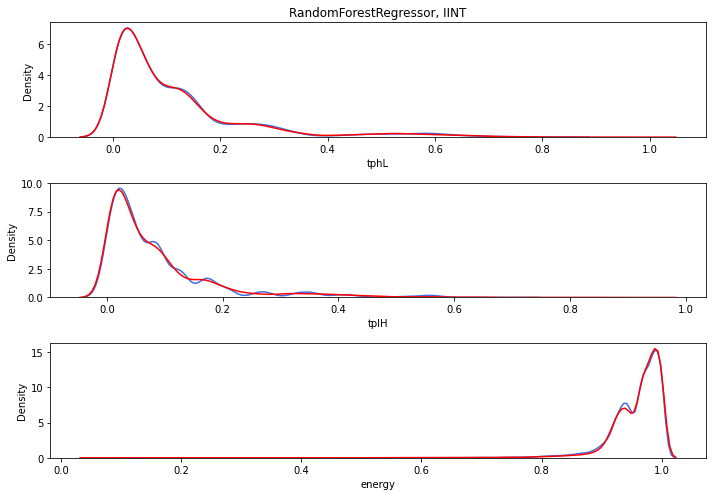

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [168]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

#modelos para TPHL
print('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 100,
                   max_depth = 5)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 5,
                   max_depth = 5)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 100,
                   max_depth = 10)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig('RF_all_best_hyperparams_inverter.pdf')
plt.show()


"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

### SVR RBF

In [ ]:
params = {'gamma': [.03125, .0625, .125, .25, 4],
          'C': [.25, .5, 1, 2, 10]}

SVR_model_cv_gs = SVR(kernel='rbf')

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(SVR_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

#### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))

In [ ]:
SVR_cv_results_TPHL("SVR_tphL_HyperParameters.csv")
SVR_cv_results_TPLH("SVR_tplH_HyperParameters.csv")
SVR_cv_results_iint.to_csv("SVR_energy_HyperParameters.csv")

In [ ]:
SVR_model_cv_gs = SVR(kernel='rbf', random_state = seed)

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""
                           
# treinando um modelo com a melhor combinação de hiperparâmetros
SVR_model_cv_gs.fit(X_scal_training, y_scal_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [ ]:
y_scal_pred = SVR_model_cv_gs.predict(X_scal_test)

In [ ]:
print(np.concatenate((y_scal_pred.reshape(len(y_scal_pred),3), y_scal_test.reshape(len(y_scal_test),3)), axis=1))

# Neural Networks

In [ ]:
import tensorflow as tf

## Neural Net #0 (Try hard mode)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

###**TPHL**

In [ ]:
ann.fit(X_train,y_train.tphl, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0054
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.3023e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3005e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.0970e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 9.3712e-05
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.6630e-05
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.4781e-05
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.2229e-05
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.0173e-05
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.6979e-05
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.4878e-05
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tphl, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 5.659724973517145e-05


Text(0.5, 1.0, 'ANN, TPHL')

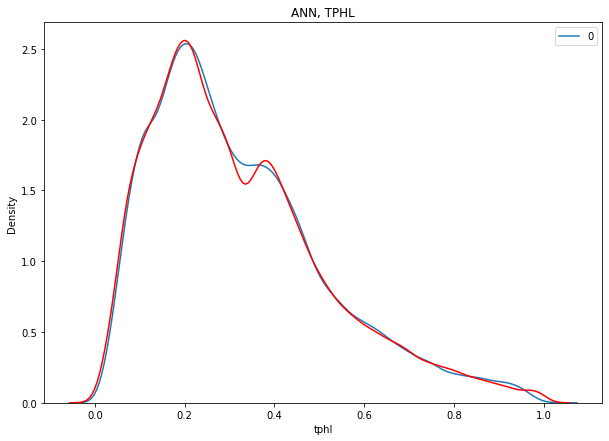

In [ ]:
fig_tphl, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPHL')

###**TPLH**

In [ ]:
ann.fit(X_train,y_train.tplh, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 5.3271e-04
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.6928e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.5479e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4872e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4467e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4033e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3642e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3444e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3278e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3065e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3020e-04
Epoch 12/50
5777/5777 [==================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tplh, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00010841889629696702


Text(0.5, 1.0, 'ANN, TPLH')

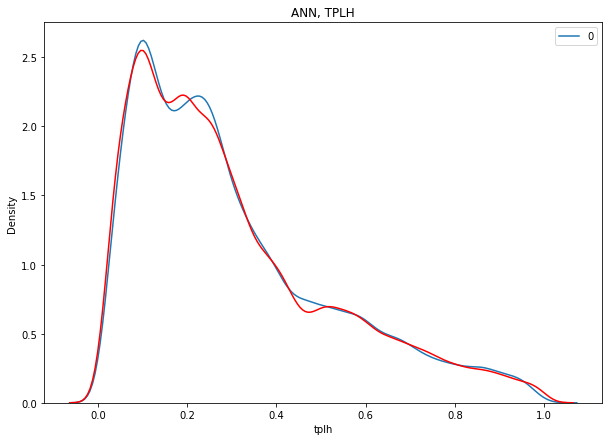

In [ ]:
fig_tplh, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPLH')

###**IINT**

In [ ]:
ann.fit(X_train,y_train.iint, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0015
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 3.2178e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.9526e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.8470e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7587e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7122e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6758e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6661e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6319e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.5917e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.4992e-04
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.iint, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00016256548097748116


Text(0.5, 1.0, 'ANN, IINT')

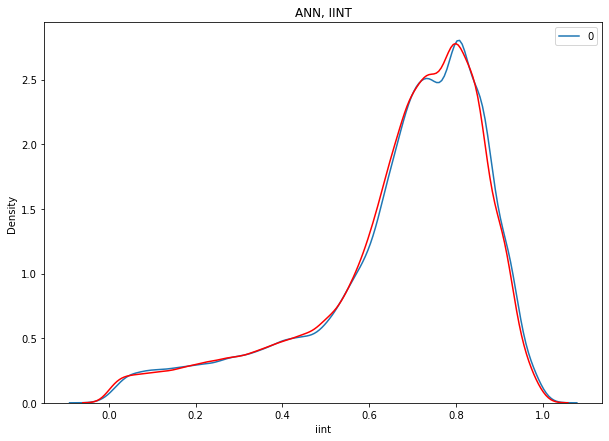

In [ ]:
fig_iint, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, IINT')

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100, ),
                                    early_stopping = True, )

###TPHL

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tphl, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0012760736147303222


Text(0.5, 1.0, 'MLP, TPHL')

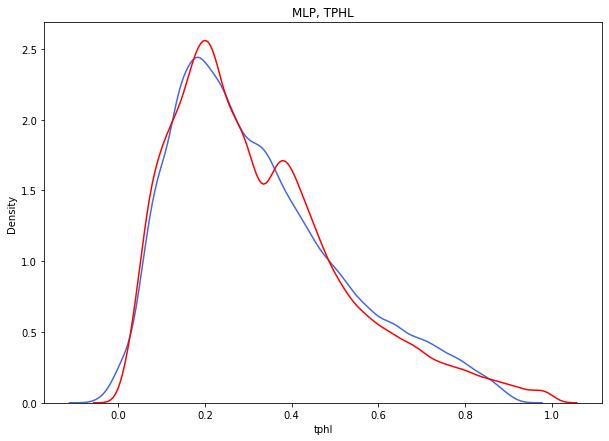

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPHL')

Score on training set: 0.967
Score on validation set: 0.967
Mean squared error (MSE): 0.0012760736147303222


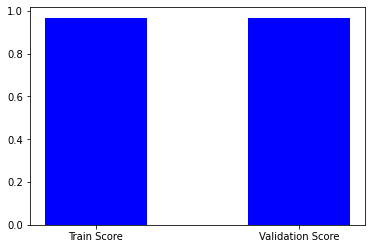

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tphl)))
y = [neural_network_model.score(X_train, y_train.tphl), 
     neural_network_model.score(X_val, y_val.tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tphl, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###TPLH

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tplh)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tplh, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0003523014496010987


Text(0.5, 1.0, 'MLP, TPLH')

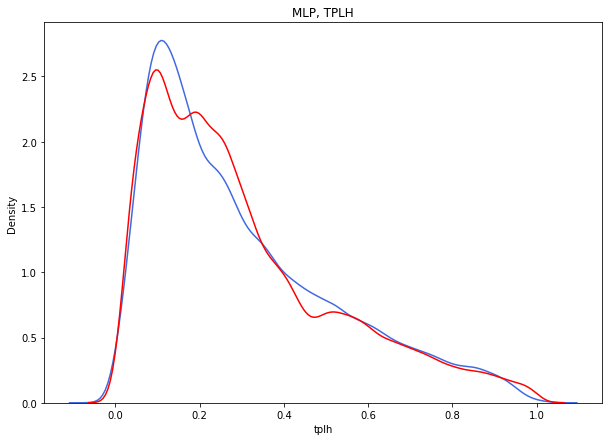

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPLH')

Score on training set: 0.993
Score on validation set: 0.993
Mean squared error (MSE): 0.0003523014496010987


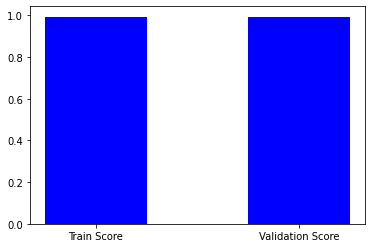

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tplh)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tplh)))
y = [neural_network_model.score(X_train, y_train.tplh), 
     neural_network_model.score(X_val, y_val.tplh)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tplh, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###IINT

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.iint)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.iint, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0005599333245738104


Text(0.5, 1.0, 'MLP, IINT')

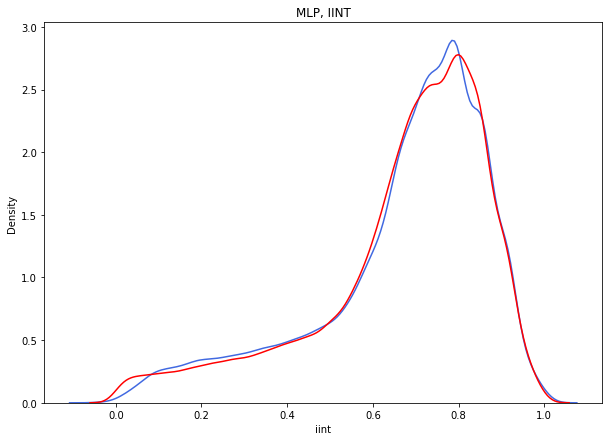

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, IINT')

Score on training set: 0.987
Score on validation set: 0.987
Mean squared error (MSE): 0.0005599333245738104


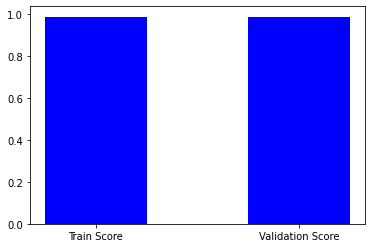

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.iint)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.iint)))
y = [neural_network_model.score(X_train, y_train.iint), 
     neural_network_model.score(X_val, y_val.iint)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.iint, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

# Old Models



## Neural Net #0 (Try hard mode)

In [ ]:
import tensorflow as tf

In [ ]:
ann = tf.keras.models.Sequential()

Vou fazer apenas um output inicialmente (tphl, coluna 0) para ver como performa, abaixo é o código para a arquitetura e compilação com backpropagation. Vou fazer sem padronizar os dados de treinamento inicialmente

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
validation_tphl = y_val.tphl
train_tphl = y_train.tphl
test_tphl = yte

Bruh, o loss diminuiu bastante e até convergiu no epoch 6, mas as predições estão constantes... wtf? Tentarei normalizar, vamos ver se altera algo, se não é mexer na arquitetura pq o modelo não está aprendendo. Aparentemente o sem alterar os dados convergiu no 30 epoch tmb. Scheisse. A normalização ainda converge, porém os resultados constantes são mais próximos da escala esperada. Vou trabalhar com ela e ver se altero a arquitetura e outros parãmetros como o batch size. O batch size e as units não me parecem trazer alterações relevantes. Vou adicionar mais Layers na esperança de a ann aprender algo a mais, minha última alternativa é alterar a composição do dataset. O aumento para 4 layers com 12 units piorou os resultados

In [ ]:
ann.fit(X_train,train_tphl, batch_size=40, epochs=50)

In [ ]:
y_pred_nn0 = ann.predict(X_val)
#np.set_printoptions(precision=2)
print(np.concatenate((y_pred_nn0.reshape(len(y_pred_nn0),1), a.reshape(len(a),1)), axis=1))

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)"""

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_norm, train_tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_norm)

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[-1.35e-04  9.68e-12]
 [ 1.02e-04  1.35e-11]
 [-5.48e-03  7.57e-12]
 ...
 [-1.57e-04  8.69e-12]
 [-1.75e-04  1.37e-11]
 [-1.91e-04  5.91e-12]]


Score on training set: -598198417686226560.000
Score on validation set: -601938109190083200.000
Explained variance score: -6.019363056862876e+17
Mean absolute error (MAE): 0.002912541559344496
Mean squared error (MSE): 1.3897360339482752e-05
R² Score: -601938109190083200.000


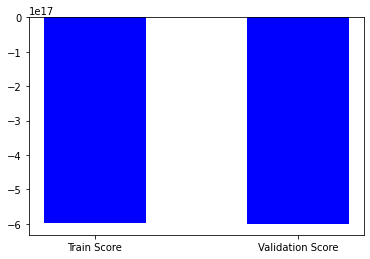

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_norm, train_tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_norm, validation_tphl)))
y = [neural_network_model.score(X_train_norm, train_tphl), 
     neural_network_model.score(X_val_norm, validation_tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {}".format(explained_variance_score(validation_tphl, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(validation_tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(validation_tphl, y_pred)))
print("R² Score: {:.3f}".format(r2_score(validation_tphl, y_pred)))

##Neural Net #2 (Keras with multioutput)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model
  
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = 7, 3
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

TypeError: ignored

In [ ]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction for new data
yhat = model.predict(X_val)
print('Predicted: %s' % yhat[0])

## Random Forest MultiOutput

In [ ]:
##### RandomForest tphl
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_model =  MultiOutputRegressor(RandomForestRegressor(random_state=seed)).fit(X_train, y_train)

y_pred_1 = rf_model.predict(X_val)

In [ ]:
print(np.concatenate((y_pred_1.reshape(len(y_pred_1),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.25e-11  2.34e-11 -1.46e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, y_pred_1, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, y_pred_1, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [5.33e-15 1.89e-15 2.00e-15]
Mean absolute error (MAE): [3.85e-12 1.14e-11 3.63e-16]
Mean squared error (MSE): [2.31e-23 2.03e-22 2.25e-31]


In [ ]:
from sklearn.model_selection import GridSearchCV
"""
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 7],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) """

'\nparams = {\'n_estimators\': [5, 50, 100, 500],\n          \'max_features\': [2, 5, 7],\n          \'max_depth\': [2, 5, 10, 50],\n          \'min_samples_split\': [2, 8, 15, 30],}\n\n# criando o objeto do modelo com RandomForestRegressor\nrf_model_cv_gs = RandomForestRegressor(random_state = seed)\n\n# criando o objeto do grid search com GridSearchCV\ngrid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3\n\n# treinando o modelo com o grid search\ngrid_search.fit(X_training, y_training)\n\n# imprimindo a melhor combinação de hiperparâmetros\nprint(\'\n Best hyperparameters:\')\nprint(grid_search.best_params_)\n\n# pegando os resultados da validação cruzada (cv_results)\ncv_results = pd.DataFrame(grid_search.cv_results_)\n\n# imprimindo o score médio nas bases de treino\nprint("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],\n                  

In [ ]:
"""Best hyperparameters:
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
Average Score on train set: -0.000 +/- 0.000
Average Score on validation set: -0.000 +/- 0.000"""

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""

rf_model_cv_gs = RandomForestRegressor(random_state = seed)

rf_model_cv_gs.set_params(n_estimators = 100,
                           max_features = 2,
                           max_depth = 2,
                           min_samples_split = 2)
# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalize(X_training), y_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [ ]:
pred = rf_model_cv_gs.predict(normalize(X_test))
print(np.concatenate((pred.reshape(len(pred),3), y_test.reshape(len(y_test),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  6.59e-12  7.30e-12 -2.95e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.78e-12  5.21e-12 -1.90e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  9.29e-12  1.76e-11 -1.44e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.86e-12  1.34e-11 -1.41e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.53e-11  2.20e-11 -1.52e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.49e-12  5.95e-12 -1.60e-15]]


##SVR Polynomial MultiOutput


In [ ]:
from sklearn.svm import SVR
SVR = MultiOutputRegressor(SVR(kernel = 'linear')).fit(normalize(X_train), y_train) # kernel='rbf', C, gamma
svr_pred = SVR.predict(normalize(X_val))

In [ ]:
print(np.concatenate((svr_pred.reshape(len(svr_pred),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.68e-11  3.61e-11 -1.85e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.68e-11  3.61e-11 -1.85e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.68e-11  3.61e-11 -1.85e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, svr_pred, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, svr_pred, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, svr_pred, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [ 5.44e-15  1.89e-15 -6.66e-16]
Mean absolute error (MAE): [5.68e-12 1.71e-11 5.51e-16]
Mean squared error (MSE): [4.19e-23 3.64e-22 3.75e-31]


# Results

In [ ]:
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
def generate_model_scores_df(score,y_pred,model_name,new_df=True,df=None):
  if new_df:
    result = pd.DataFrame(columns=['TPHL', 'TPLH', 'IINT'], index=[model_name])
  else:
    result = df
  result.loc[model_name] = score(y_val, y_pred, multioutput='raw_values')
  return result

In [ ]:
sim_0 = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/results_sim0.csv')

In [ ]:
#regre = mean_absolute_error(y_val, y_p, multioutput='raw_values')
randf1 = mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')
#randf2 = mean_absolute_error(y_val, y_pred_2, multioutput='raw_values')
NN = mean_absolute_error(y_val,y_pred, multioutput='raw_values')
#NN2 = mean_absolute_error(y_val,yhat, multioutput='raw_values')

In [ ]:
metricas = pd.DataFrame([randf1,NN],index=['Floresta','MLP'],columns=['tphl','tplh','iint'])

In [ ]:
metricas

,tphl,tplh,iint
Floresta,3.846058e-12,1.137435e-11,3.628414e-16
MLP,3.030069e-04,8.922528e-05,9.800367e-05
